#  Прогнозирование количества заказов такси в аэропорту

## Задача <a class = "tocSkip">

Построить модель для прогнозирования количества заказов такси в аэропортах на следующий час для агрегатора такси.

На основе предсказаний модели планируется привлекать больше водителей в периоды пиковой нагрузки.

Модель должна демонстрировать качество прогноза `RMSE` не больше `48` на тестовой выборке размером 10% от исходных данных.

## Предоставленные данные <a class = "tocSkip">

Исторические данные компании о заказах такси в аэропортах.

Согласно описанию к данным, количество заказов (целевой признак) — значения столбца `num_orders`.

## План работы <a class = "tocSkip">

Мы планируем, что работа над задачей будет включать шесть этапов:

1. загрузка и первичное изучение данных;
2. подготовка данных для исследовательского анализа;
3. исследовательский анализ данных;
4. подготовка данных для обучения моделей;
5. обучение моделей; и
6. тестирование моделей.

## Подготовка к работе <a class = "tocSkip">

Загрузим и импортируем необходимые библиотеки:

In [1]:
# загрузка библиотек
!pip install -q optuna
!pip install -q catboost
!pip install -q statsforecast

In [ ]:
# импорт библиотек

# общие, работа с данными
import os
import six
import joblib
import warnings
import numpy as np
import pandas as pd

# исследовательский анализ данных
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import MO, TH, WeekdayLocator
from statsmodels.tsa.seasonal import seasonal_decompose

# подготовка данных
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

# ML модели
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

# статистические модели
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, MSTL, SeasonalNaive

# оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import ExperimentalWarning

# отбор признаков
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

# оценка моделей
from sklearn.metrics import mean_squared_error

Настроим параметры отображения графиков и предупреждений:

In [3]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

# настройка отображения предупреждений
optuna.logging.set_verbosity(optuna.logging.WARNING) 
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = ExperimentalWarning)

Зафиксируем значение параметра `random_state` для всего ноутбука:

In [4]:
# фиксирование значения параметра random_state
random_state = 12345

## Загрузка и первичное изучение данных

In [ ]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# указание пути к данным
path = '/content/drive/MyDrive/yandex-practicum-data-science-course-projects/airport-taxi-demand-prediction/'

Прочитаем файл с данными:

In [7]:
# чтение файла с данными
orders = pd.read_csv(os.path.join(path, 'taxi_orders.csv'))

Изучим пять первых объектов датасета:

In [8]:
# вывод на экран первых пяти объектов датасета
orders.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Мы видим, что:
- один объект содержит информацию о количестве заказов в определенные дату и время;
- по каждому объекту доступно 2 признака (включая целевой): `datetime` (календарный признак) и `num_orders` (количественный целевой признак);
- значения признака `datetime` имеют интервал 10 минут (для решения задачи необходимо ресемплировать данные);
- первые пять объектов датасета расположены в хронологическом порядке.

Изучим общую информацию о датасете:

In [9]:
# вывод на экран общей информации о датасете
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Мы видимо, что:
- в датасете 26 496 объектов;
- датасет не содержит явных пропусков;
- признак `datetime` имеет тип данных `object`; для дальнейшей работы с ним необходимо изменить его тип данных на `datetime`.

Изменим тип данных признака `datetime`:

In [10]:
# изменение типа данных столбца datetime
orders['datetime'] = pd.to_datetime(orders['datetime'])

# проверка изменения типа данных
orders.dtypes

datetime      datetime64[ns]
num_orders             int64
dtype: object

Проверим, что все значения признака `datetime` идут по порядку:

In [11]:
# проверка признака datetime на монотонность
print(f'Все значения признака datetime идут по порядку: {orders.datetime.is_monotonic_increasing}')

Все значения признака datetime идут по порядку: True


Проверим датасет на дубликаты:

In [12]:
# вывод на экран количества дубликатов
print(f'Количество дубликатов: {orders.duplicated().sum()}')

Количество дубликатов: 0


### Выводы

На данном этапе мы загрузили данные и провели их первичное изучение.

По его итогам мы установили:

- в датасете 26 496 объектов;
- один объект содержит информацию о количестве заказов в определенные дату и время;
- по каждому объекту доступно 2 признака (включая целевой): `datetime` (календарный признак) и `num_orders` (количественный целевой признак);
- значения признака `datetime` имеют интервал 10 минут (для решения задачи необходимо ресемплировать данные) и расположены в хронологическом порядке;
- датасет не содержит явных пропусков и дубликатов.

На следующем этапе подготовим данные для исследовательского анализа.

## Подготовка данных для исследовательского анализа

На данном этапе ресемплируем данные. Для этого установим столбец `datetime` в качестве индекса:

In [13]:
# установка столбца datetime в качестве индекса
orders.set_index('datetime', inplace = True)

# проверка установки нового индекса
orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Ресемплируем данные, используя интервал `1 час`: 

In [14]:
# ресемплирование данных
orders = orders.resample('1H').sum()

# проверка ресемплирования
orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Исследовательский анализ данных

На данном этапе исследуем:
- распределение значений количества заказов в час; и
- временной ряд.

### Количество заказов в час

Исследуем распределение значений количества заказов в час:

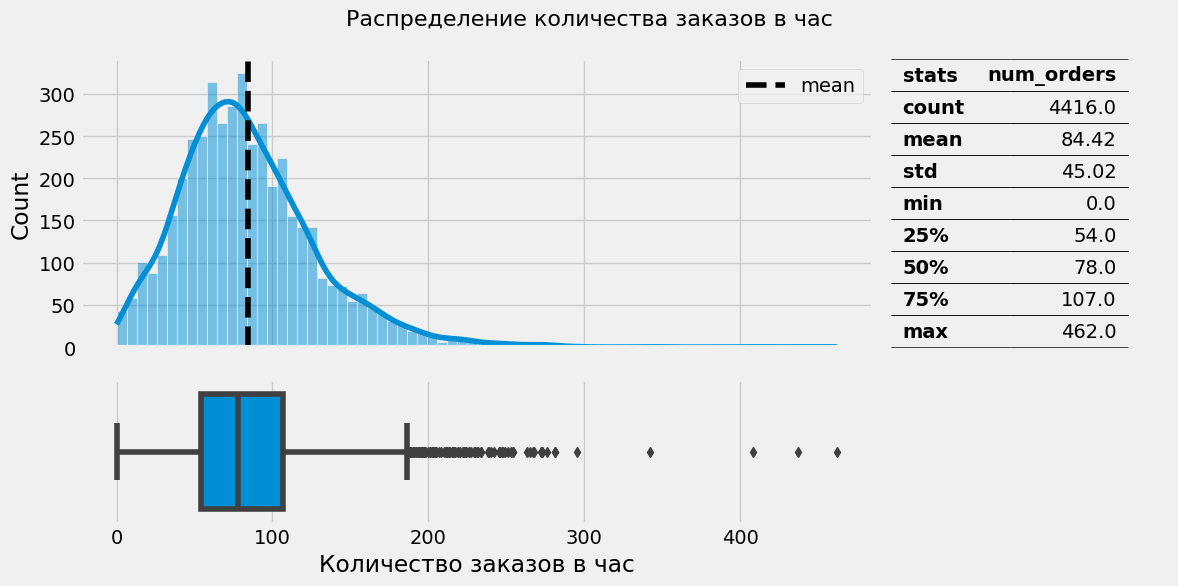

In [15]:
# вывод на экран описательной статистики и 
# графиков оценки распределения ядра в отнощении количества заказов в час
feature_stats = orders.describe().round(2).reset_index()
feature_stats.rename(columns = {'index' : 'stats'}, 
                     inplace = True)

fig, ax = plt.subplots(nrows         = 2,
                       ncols         = 2,
                       figsize       = (12, 6),
                       width_ratios =  [4, 1],
                       height_ratios = [2, 1],
                       sharex        = True)

ax = ax.flatten()

sns.histplot(data = orders, 
             kde  = True, 
             ax   = ax[0])

ax[0].axvline(x         = orders.num_orders.mean(), 
              color     = 'black', 
              linestyle = '--',
              label= 'mean')

ax[0].legend()

the_table = ax[1].table(cellText  = feature_stats.values, 
                        colLabels = feature_stats.columns, 
                        bbox      = (-0.4, 0, 1.2, 1),
                        # colWidths = [0.1, 0.45, 0.45],
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

sns.boxplot(x          = orders.num_orders,
            saturation = 1,
            ax         = ax[2])

ax[2].set_xlabel('Количество заказов в час')

ax[3].axis('off')

fig.suptitle('Распределение количества заказов в час', fontsize = 16)

plt.tight_layout()
plt.show()

- данные распределены ассиметрично (наблюдается позитивная скошенность);
- есть выбросы начиная с 180 заказов

Изучим среднее количество заказов в час в течение дня, недели, месяца и года:

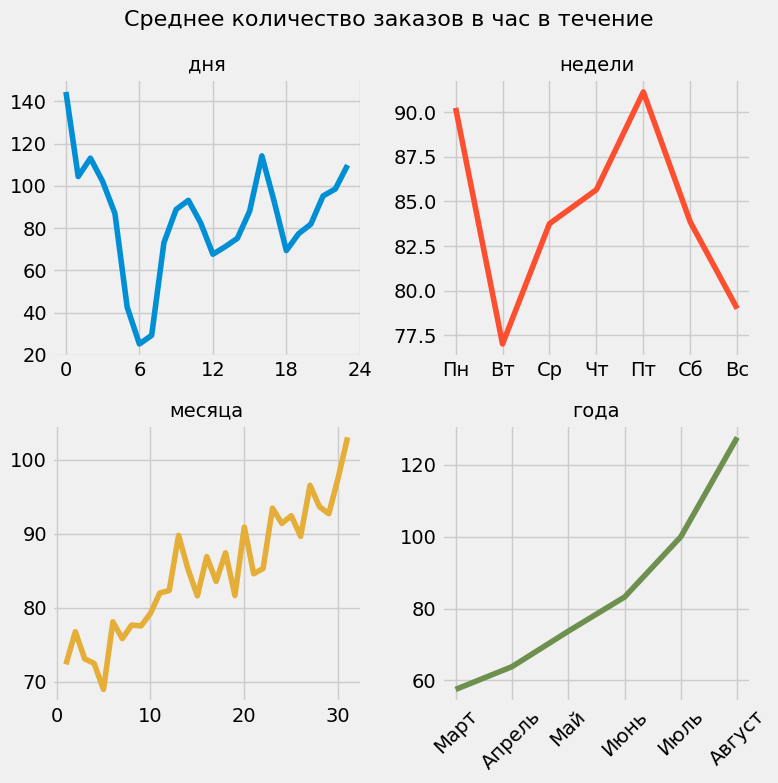

In [16]:
# вывод на экран графиков среднего количества заказов в час в течение дня, недели, месяца и года
fig, ax = plt.subplots(nrows         = 2,
                       ncols         = 2,
                       figsize       = (8, 8))

ax = ax.flatten()

orders.groupby(orders.index.hour).num_orders.mean().plot(ax = ax[0])

orders.groupby(orders.index.weekday).num_orders.mean().plot(ax    = ax[1], 
                                                            color = '#fc4f30')

orders.groupby(orders.index.day).num_orders.mean().plot(ax    = ax[2],
                                                        color = '#e5ae38')

orders.groupby(orders.index.month).num_orders.mean().plot(ax    = ax[3],
                                                          color = '#6d904f')

xticks = np.arange(0, 25, 6)
ax[0].set_xticks(xticks)

xticks = np.arange(0, 7)
ax[1].set_xticks(xticks)

week_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
ax[1].set_xticklabels(week_labels)

xticks = np.arange(3, 9)
ax[3].set_xticks(xticks)

month_labels = ['Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август']
ax[3].set_xticklabels(month_labels, rotation = 45)

ax[0].set_title('дня', fontsize = 14)
ax[1].set_title('недели', fontsize = 14)
ax[2].set_title('месяца', fontsize = 14)
ax[3].set_title('года', fontsize = 14)

for axi in ax:
    axi.set_xlabel(None)

fig.suptitle('Среднее количество заказов в час в течение', fontsize = 16)

plt.tight_layout()
plt.show()

Мы наблюдаем:
- дневную и недельную сезонность (используем данные наблюдения при создании признаков); и
- восходящий годовой тренд

### Временной ряд

In [17]:
# вывод на экран самой ранней и самой поздней дат датасета
print(f'Датасет содержит данные за период с {str(orders.index.date.min())} по {str(orders.index.date.max())}.')

Датасет содержит данные за период с 2018-03-01 по 2018-08-31.


- для решения задачи были предоставлены данные за 7 месяцев

Изучим временной ряд:

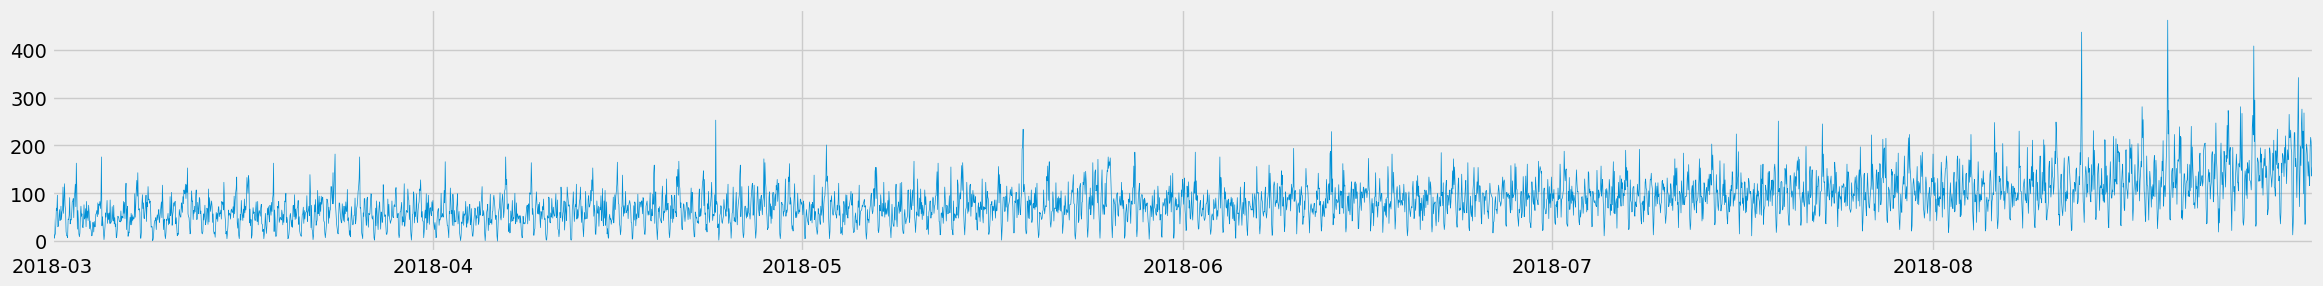

In [18]:
# вывод на экран временного ряда
fig = plt.figure(figsize = (26, 3))

plt.plot(orders, linewidth = 0.5)

plt.xlim((orders.index.min(), orders.index.max()))

plt.show()

Мы наблюдаем:
- восходящий тренд; а также
- увеличение амплитуды количества заказов в час ближе к концу временного ряда.

Проверим временной ряд на стационарность, используя тест Дики-Фуллера:

In [19]:
# проведение теста Дики-Фуллера
result = adfuller(orders)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


- временной ряд стационарен

Изучим компоненты временного ряда: тренд, сезонность и остаток:

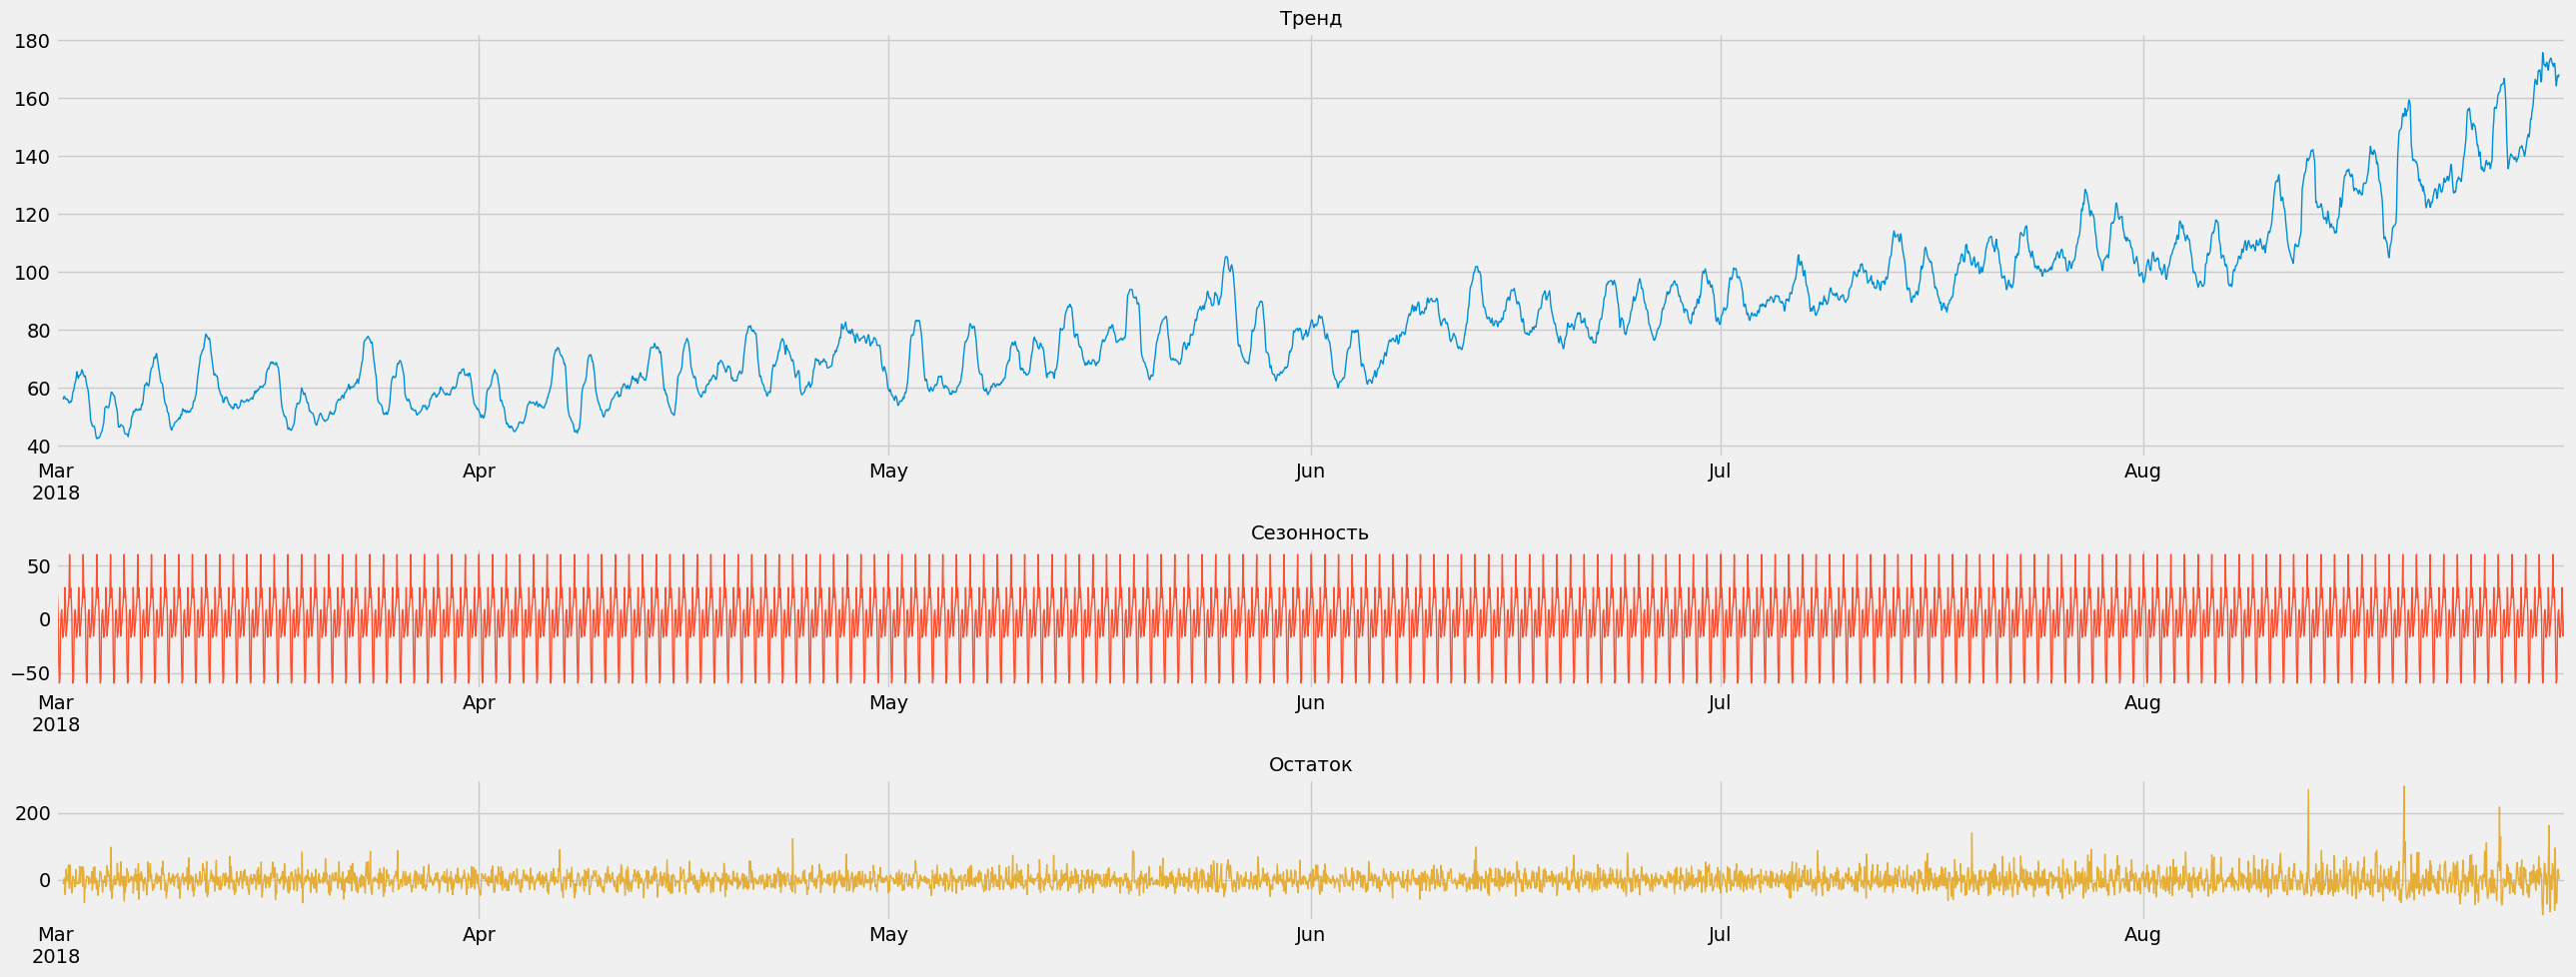

In [20]:
# декомпозирование временного ряда на тренд, сезонность и остаток
decomp = seasonal_decompose(orders, period = 24)

# вывод на экран тренда, сезонности и остатка
fig, ax = plt.subplots(nrows         = 3,
                       ncols         = 1,
                       figsize       = (26, 10),
                       height_ratios = [3, 1, 1])

decomp.trend.plot(linewidth = 1,
                  xlabel    = '', 
                  ax        = ax[0])

decomp.seasonal.plot(linewidth = 1,
                     xlabel = '', 
                     color  = '#fc4f30',
                     ax     = ax[1])

decomp.resid.plot(linewidth = 1,
                  xlabel = '', 
                  color  = '#e5ae38',
                  ax     = ax[2])

ax[0].set_title('Тренд', 
                fontsize = 14)

ax[1].set_title('Сезонность',
                fontsize = 14)

ax[2].set_title('Остаток',
                fontsize = 14)

plt.tight_layout()
plt.show()

Мы наблюдаем:
- восходящий тренд; 
- стабильную дневную сезонность; а также
- увеличение амплитуды остатка ближе к концу временного ряда.

Изучим автокорреляцию и частичную автокорреляцию временного ряда:

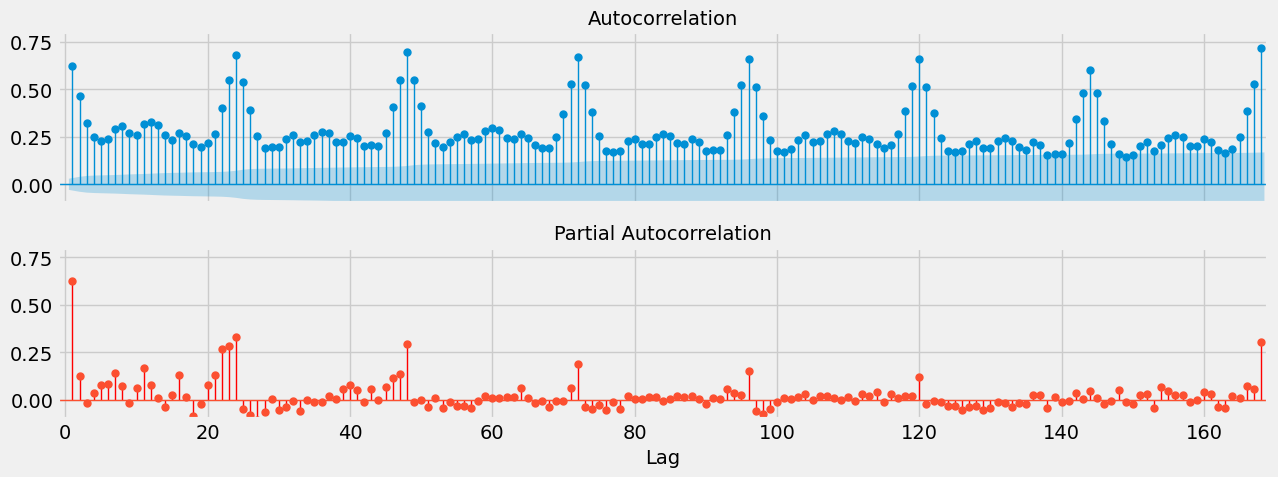

In [21]:
# вывод на графиков автокорреляции и частичной автокорреляции
fig, ax = plt.subplots(nrows   = 2,
                       figsize = (13, 5),
                       sharex = True)

tsaplots.plot_acf(orders, 
                  lags          = 168,
                  zero = False,
                  vlines_kwargs = {'linewidth' : 1},
                  linewidth = 1, 
                  ax            = ax[0])

tsaplots.plot_pacf(orders, 
                   lags          = 168,
                   zero = False,
                   alpha = 0,
                   vlines_kwargs = {'linewidth' : 1, "colors": 'red'},
                   color = '#fc4f30',
                   linewidth = 1, 
                   ax=ax[1])

for i in range(2):
    ax[i].set_xlim((-1, 169))
    ax[i].set_ylim((-0.1, 0.8))

ax[1].set_xlabel('Lag', fontsize = 14)

ax[0].set_title('Autocorrelation', fontsize = 14)
ax[1].set_title('Partial Autocorrelation', fontsize = 14)

plt.tight_layout()
plt.show()

Мы наблюдаем сильную автокорреляцию `lag 0` с `lag 1`, `lag 24`, `lag 48`, `lag 72`, `lag 96`, `lag 120`, `lag 144` и `lag 168` (используем данные наблюдения при создании признаков).

### Выводы

На данном этапе мы исследовали:
- распределение значений количества заказов в час; и
- временной ряд.

**Количество заказов в час**

- данные распределены ассиметрично (наблюдается позитивная скошенность);
- есть выбросы начиная с 180 заказов.

**Времеменной ряд** 

Для решения задачи были предоставлены данные за 7 месяцев.
Временной ряд стационарен.

Мы наблюдали:
- восходящий тренд; 
- дневную и недельную сезонности (используем данные наблюдения при создании признаков);
- увеличение амплитуды остатка ближе к концу временного ряда; а также
- сильную автокорреляцию `lag 0` с `lag 1`, `lag 24`, `lag 48`, `lag 72`, `lag 96`, `lag 120`, `lag 144` и `lag 168` (используем данные наблюдения при создании признаков).

## Подготовка данных для обучения моделей

На данном этапе:

- создадим дополнительные признаки;
- создадим отдельные переменные с признаками и целевым признаком;
- разделим данные на обучающую и тестовую выборки;
- подготовим обучающую выборку для статистических моделей.

### Создание дополнительных признаков

На основе исследовательского анализа данных создадим три группы дополнительных признаков:
- календарные признаки;
- lag; и
- rolling mean, median, min, max.

In [22]:
# создание календарных признаков
orders['month'] = orders.index.month
orders['day'] = orders.index.day
orders['weekday'] = orders.index.weekday
orders['weekend'] = (orders.index.weekday > 4).astype(int)
orders['hour'] = orders.index.hour

# проверка создания признаков
orders.head()

,num_orders,month,day,weekday,weekend,hour
datetime,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0
2018-03-01 01:00:00,85,3,1,3,0,1
2018-03-01 02:00:00,71,3,1,3,0,2
2018-03-01 03:00:00,66,3,1,3,0,3
2018-03-01 04:00:00,43,3,1,3,0,4


In [23]:
# создание признаков lag
for lag in [1, 2, 3, 4, 5, 24, 48, 72, 96, 120, 144, 168]:
    orders['lag_{}'.format(lag)] = orders['num_orders'].shift(lag)
    
# проверка создания признаков
orders.head()

,num_orders,month,day,weekday,weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_24,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,0,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,0,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,0,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,0,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# создание признаков rolling mean, median, min, max
for statistic in ['mean', 'median', 'min', 'max']:
    for window in [6, 12, 24, 24 * 2, 24 * 3, 24 * 4, 24 * 5, 24 * 6, 24 * 7]:
        orders['rolling_{}_{}'.format(statistic, window)] = orders['num_orders'].rolling(
            window, closed='left', min_periods=window).agg(statistic)

# проверка создания признаков
orders.tail()

,num_orders,month,day,weekday,weekend,hour,lag_1,lag_2,lag_3,lag_4,...,rolling_min_168,rolling_max_6,rolling_max_12,rolling_max_24,rolling_max_48,rolling_max_72,rolling_max_96,rolling_max_120,rolling_max_144,rolling_max_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,4,0,19,207.0,217.0,197.0,116.0,...,13.0,217.0,217.0,276.0,342.0,342.0,342.0,408.0,408.0,408.0
2018-08-31 20:00:00,154,8,31,4,0,20,136.0,207.0,217.0,197.0,...,13.0,217.0,217.0,276.0,342.0,342.0,342.0,408.0,408.0,408.0
2018-08-31 21:00:00,159,8,31,4,0,21,154.0,136.0,207.0,217.0,...,13.0,217.0,217.0,276.0,342.0,342.0,342.0,408.0,408.0,408.0
2018-08-31 22:00:00,223,8,31,4,0,22,159.0,154.0,136.0,207.0,...,13.0,217.0,217.0,276.0,342.0,342.0,342.0,408.0,408.0,408.0
2018-08-31 23:00:00,205,8,31,4,0,23,223.0,159.0,154.0,136.0,...,13.0,223.0,223.0,276.0,342.0,342.0,342.0,408.0,408.0,408.0


### Создание отдельных переменных с признаками и целевым признаком

In [25]:
# создание переменных features и target с признаками и целевым признаком
features = orders.drop(columns = ['num_orders'])
target = orders['num_orders']

# проверка создания переменных
for subset_name, subset in zip(['features', 'target'], [features, target]):
    print(subset_name)
    print(subset.shape)
    print()

features
(4416, 53)

target
(4416,)



### Разделение данных на обучающую и тестовую выборку

При разделении данных используем предусмотренную задачей пропорцию `9:1`:

In [26]:
# разделение данных на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size    = 0.1, 
                                                                            random_state = random_state,
                                                                            shuffle      = False)

# создание словаря с признаками и целевым признаком по каждой выборке
subsets_dict = {'features_train' : features_train,
                'features_test'  : features_test,
                'target_train'   : target_train,
                'target_test'    : target_test}

# проверка разделения данных
for subset_name, subset in subsets_dict.items():
    print(subset_name)
    print(subset.shape)
    print()

features_train
(3974, 53)

features_test
(442, 53)

target_train
(3974,)

target_test
(442,)



Удалим пропуски в обучающей выборке, которые образовались в результате создания дополнительных признаков:

In [27]:
# удаление пропущенных значений
features_train.dropna(inplace = True)
target_train = target_train[features_train.index]

# проверка удаления пропущенных значений
print(f'Количество пропусков в обучающей выборке: {features_train.isna().sum().sum()}')

Количество пропусков в обучающей выборке: 0


### Подготовка обучающей выборки для статистических моделей

Мы планируем обучить статистические модели из библиотеки `statsforecast`, которая предъявляет специальные требования к обучающей выборке:
- наличие константного столбца `unique_id`;
- специальные названия столбцов.

С их учетом подготовим обучающую выборку для статистических моделей:

In [28]:
# сброс индекса
target_train_stat = target_train.reset_index()

# создание константного признака unique_id
target_train_stat['unique_id'] = 'num_orders'

# переименование стобцов num_orders и datetime
target_train_stat.rename(columns = {'num_orders' : 'y', 
                                    'datetime' : 'ds'}, 
                         inplace = True)

# проверка подготовки обучающей выборки для статистических моделей
target_train_stat.head()

,ds,y,unique_id
0,2018-03-08 00:00:00,143,num_orders
1,2018-03-08 01:00:00,78,num_orders
2,2018-03-08 02:00:00,65,num_orders
3,2018-03-08 03:00:00,68,num_orders
4,2018-03-08 04:00:00,60,num_orders


### Выводы

На данном этапе мы:

- создали дополнительные признаки (календарные признаки, lag и rolling mean, median, min, max);
- создали отдельные переменные с признаками и целевым признаком;
- разделили данные на обучающую и тестовую выборки; и
- подготовили обучающую выборку для статистических моделей.

Теперь мы можем перейти к обучению моделей.

## Обучение моделей

In [29]:
# фиксирование количества сплитов для TimeSeriesSplit
splits = 9

# создание объекта структуры TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits = splits)

# создание объекта TPESampler для воспроизводимости результатов оптимизации гиперпараметров
sampler = TPESampler(seed = random_state)

Для удобства обучения и отбора признаков создадим:
- класс `MyPipeline` (для отбора признаков при помощи `RFECV` для моделей с пайплайнами для препроцессинга признаков);
- функцию `plot_scores` (для визуализации метрики);
- функцию `plot_param_importances` (для визуализации важности гиперпараметров); и
- функцию `plot_permutation_importances` (для визуализации важности признаков);

In [30]:
# создание класса MyPipeline
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

In [31]:
# создание функции plot_scores
def plot_scores(data, title, height):
    '''
    Функция строит столбчатый график значений RMSE по каждой модели.
    
    Параметры:
    - data — данные для построения графика;
    - title — название графика;
    - height — высота графика.
    '''

    data = data.sort_values(ascending = False)

    fig = plt.figure(figsize = (7, height))
        
    bars = plt.barh(y      = data.index,
                    width  = data.values,
                    height = 0.5)
    
    plt.plot((48, 48), 
             (-1, len(data)),
             color     = '#8b8b8b',
             linestyle = '--')

    plt.bar_label(bars, 
                  fmt     = '%.4g', 
                  padding = 5)
        
    plt.text(x     = 49, 
             y     = len(data) // 2, 
             s     = 'target RMSE', 
             color = '#8b8b8b')

    plt.xlabel('RMSE', fontsize = 14)

    plt.xlim((20, 55))
    plt.ylim((-0.5, len(data)-0.5))
    
    plt.grid(axis='y')

    fig.suptitle(title, fontsize = 16)

    plt.tight_layout()
    plt.show()

In [32]:
def plot_param_importances(study, model_name, height):
    '''
    Функция строит столбчатый график важности гиперпараметров модели.
    
    Параметры:
    - study — результаты оптимизации гиперпараметров;
    - model_name — название модели, для которой нужно построить график;
    - height — высота графика.
    '''

    hpi = optuna.importance.get_param_importances(study)
    
    fig = plt.figure(figsize = (5, height))

    bars = plt.barh(y      = list(hpi.keys())[::-1],
                   width  = list(hpi.values())[::-1],
                   height = 0.5,
                   color  = '#e5ae38')

    plt.bar_label(bars, 
                  fmt     = '%.2g', 
                  padding = 5)
    
    plt.grid(axis='y')

    plt.xlabel('Importance', fontsize = 14)

    fig.suptitle(model_name + ' Hyperparameter Importance', fontsize = 16)

    plt.tight_layout()
    plt.show()

In [33]:
def plot_permutation_importances(model, model_name, width = 13):
    '''
    Функция строит столбчатый график важности признаков модели.
    
    Параметры:
    - model — модель, для которой нужно построитьь график;
    - model_name — название модели, для которой нужно построить график;
    - width — ширина графика.
    '''
    
    model.fit(features_train, target_train)

    fi = permutation_importance(model, 
                                features_train, 
                                target_train,
                                scoring      = 'neg_mean_squared_error', 
                                n_repeats    = 10, 
                                random_state = random_state)

    inds = fi.importances_mean.argsort()[::-1]

    fig = plt.figure(figsize = (width, 4))

    bars = plt.bar(x      = features.columns[inds],
                   height = fi.importances_mean[inds],
                   width  = 0.5,
                   color  = '#6d904f')

    plt.xticks(fontsize      = 10,
               rotation      = 45, 
               ha            = 'right', 
               rotation_mode = 'anchor')

    plt.grid(axis='x')
    
    plt.ylabel('Importance', fontsize = 14)

    fig.suptitle(model_name + ' Permutation Importance', fontsize = 16)

    plt.tight_layout()
    plt.show()

### ML модели

На данном этапе обучим пять ML-моделей:
- `LinearRegression`;
- `HuberRegressor`;
- `RandomForestRegressor`;
- `CatBoostRegressor`; и
- `XGBRegressor`.

Для каждой из моделей оптимизируем гиперпараметры и проведем отбор признаков.

In [34]:
# создание моделей
lr_model = MyPipeline([
    ('preprocessor', StandardScaler()),
    ('regressor', LinearRegression())
])

hr_model = MyPipeline([
    ('preprocessor', StandardScaler()),
    ('regressor', HuberRegressor())
])

rf_model = RandomForestRegressor(random_state = random_state)

cb_model = CatBoostRegressor(random_state = random_state, 
                             verbose      = False)

xgb_model = XGBRegressor(random_state = random_state)

In [35]:
# создание списков ml_models и ml_models_names с моделями и их названиями
ml_models = [lr_model, hr_model, rf_model, cb_model, xgb_model]

ml_models_names = ['LinearRegression', 'HuberRegressor', 'RandomForestRegressor', 
                   'CatBoostRegressor', 'XGBRegressor']

# создание таблицы models_data для хранения параметров и результатов обучениея моделей
models_data = pd.DataFrame({'model_name' : ml_models_names})

# установка названий моделей в качестве индекса
models_data.set_index('model_name', inplace = True)

### ML Models Baseline Performance

Посчитаем метрики для моделей на дефолтных параметрах:

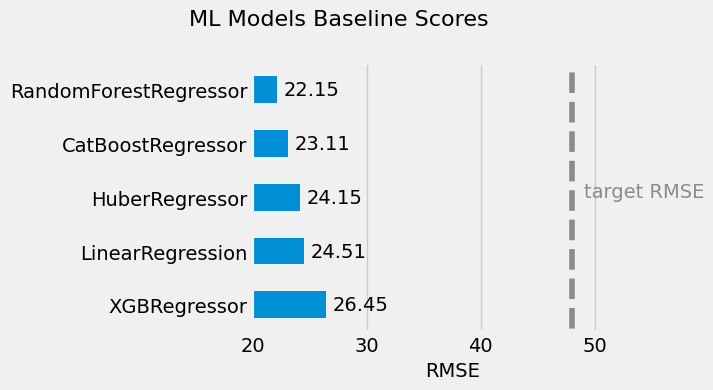

In [36]:
# для каждой ML-модели
for model_name, model in zip(ml_models_names, ml_models):
    
    # расчет среднего значения RMSE на обучающей выборке
    scores = cross_val_score(model, 
                             features_train, 
                             target_train, 
                             scoring = 'neg_mean_squared_error', 
                             cv      = tscv)
    
    # сохранение результатов
    models_data.loc[model_name, 'baseline_rmse'] = np.mean(np.sqrt(np.abs(scores)))

# вызов функции plot_scores
plot_scores(models_data.loc[ml_models_names, 'baseline_rmse'], 'ML Models Baseline Scores', 4)

- лучшее среднее значение `RMSE` на обучающей выборке показала ML-модель `RandomForestRegressor`;
- все ML-модели демонстрируют на обучающей выборке качество прогноза `RMSE` лучше целевого

### LinearRegression

У модели `LinearRegression` нет гиперпараметров для оптимизации, поэтому сразу перейдем к отбору признаков:

In [37]:
model_name = 'LinearRegression'

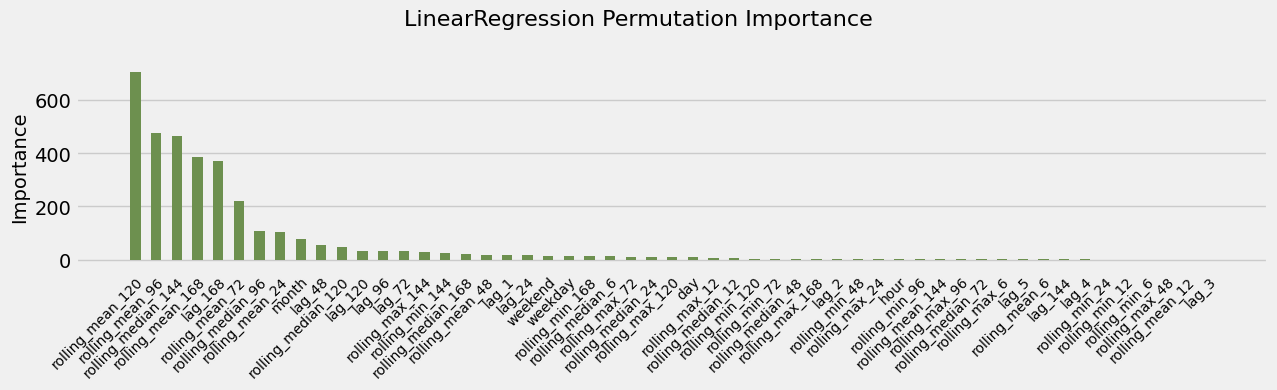

In [38]:
# вызов функции plot_permutation_importances
plot_permutation_importances(lr_model, model_name)

- наиболее важный признак — `rolling_mean_120`;
- из 10 наиболее важных признаков 7 — признаки - `rolling`;
- permutation impotances большинства признаков близки к нулю (стоит провести отбор признаков).

In [39]:
# отбор признаков
rfecv = RFECV(estimator = lr_model, 
              step      = 1, 
              cv        = tscv, 
              scoring   = 'neg_mean_squared_error')

rfecv.fit(features_train, target_train)

# создание списка с отобранными признаками
lr_features = list(rfecv.get_feature_names_out())

# вывод на экран количества и названий отобранных признаков
print(f'Оптимальное количество признаков: {rfecv.n_features_}')
print(f'Оптимальные признаки: {lr_features}')

Оптимальное количество признаков: 14
Оптимальные признаки: ['lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_168', 'rolling_mean_24', 'rolling_mean_48', 'rolling_mean_72', 'rolling_mean_96', 'rolling_mean_120', 'rolling_mean_168', 'rolling_median_96', 'rolling_median_120', 'rolling_median_144']


- в результате отбора признаков их количество сократилось в четыре раза

In [40]:
# создание препроцессора для LinearRegression с учетом отбора признаков
lr_preprocessor = ColumnTransformer(
    transformers = [('num',  StandardScaler(), lr_features)]).set_output(transform = 'pandas')

# обновление модели
lr_model_fs = MyPipeline(steps = [
    ('preprocessor', lr_preprocessor),
    ('regressor', LinearRegression())
    ])

# расчет среднего значения RMSE на обучающей выборке с учетом отбора признаков
scores = cross_val_score(lr_model_fs,
                         features_train, 
                         target_train, 
                         scoring = 'neg_mean_squared_error', 
                         cv      = tscv)

# сохранение значения RMSE в таблицу models_data
models_data.loc[model_name, 'f_selection_rmse'] = np.mean(np.sqrt(np.abs(scores)))

# вывод на экран значений rmse до и после отбора признаков
metrics_to_display = ['baseline_rmse', 'f_selection_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

,LinearRegression
baseline_rmse,24.512066
f_selection_rmse,22.33834


- отбор признаков существенно улучшил значения метрики

### HuberRegressor

In [41]:
model_name = 'HuberRegressor'

In [42]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial):
    
    # определение пространства поиска значений гиперпараметров
    params = {'regressor__alpha'   : trial.suggest_float('alpha', 1e-4, 1e4, log = True), 
              'regressor__epsilon' : trial.suggest_float('epsilon', 1, 1e4, log = True)}
    
    # обновление гиперпараметров модели
    hr_model.set_params(**params)
    
    # расчет среднего значения RMSE на обучающей выборке  
    scores = cross_val_score(hr_model, 
                             features_train, 
                             target_train, 
                             scoring = 'neg_mean_squared_error', 
                             cv      = tscv)

    return np.mean(np.sqrt(np.abs(scores)))

In [43]:
# оптимизация гиперпараметров
hr_study = optuna.create_study(direction = 'minimize', sampler = sampler)
hr_study.optimize(objective, n_trials = 100, show_progress_bar = True)

# сохранение результатов оптимизации
joblib.dump(hr_study, os.path.join(path, 'hr_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_rmse'] = hr_study.best_value
models_data.loc[model_name, 'best_params'] = [hr_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in hr_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# обновление гиперпараметров модели
hr_model['regressor'].set_params(**hr_study.best_params)

# вывод на экран значений rmse до и после оптимизации
metrics_to_display = ['baseline_rmse', 'opt_hparams_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

alpha: 14.580973839940825
epsilon: 29.05791964363868



,HuberRegressor
baseline_rmse,24.153552
opt_hparams_rmse,21.967468


- оптимизация гиперпараметров существенно улучшила значения метрики

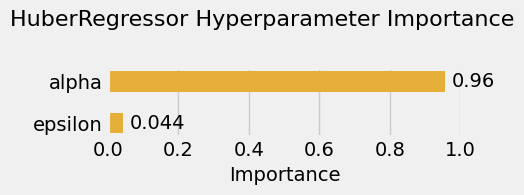

In [44]:
# вызов функции plot_param_importances
plot_param_importances(hr_study, model_name, 2)

- наиболее важный гиперпараметр (с большим отрывом) — `alpha`

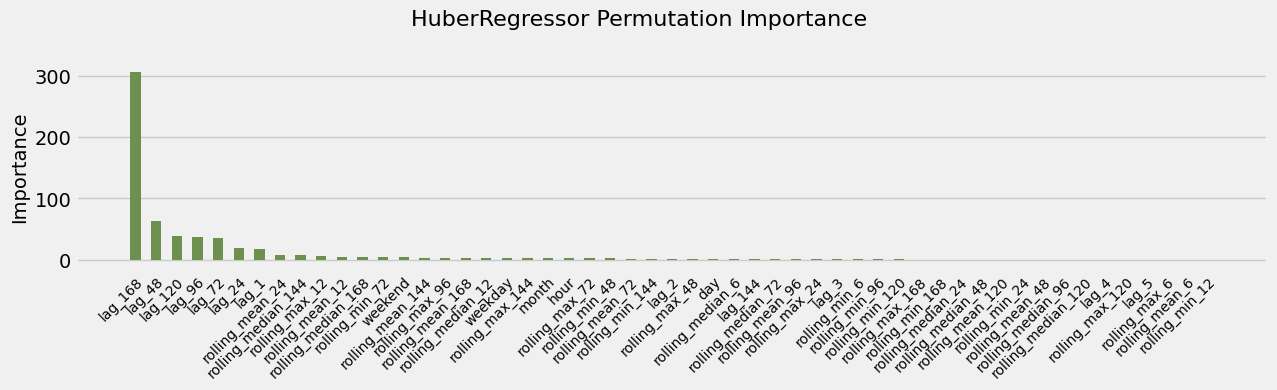

In [45]:
# вызов функции plot_permutation_importances
plot_permutation_importances(hr_model, model_name)

- наиболее важный признак (с большим отрывом) — `lag_168`;
- из 10 наиболее важных признаков 7 — признаки - `lag`;
- permutation impotances большинства признаков близки к нулю (стоит провести отбор признаков).

In [46]:
# отбор признаков
rfecv = RFECV(estimator = hr_model, 
              step      = 1, 
              cv        = tscv, 
              scoring   = 'neg_mean_squared_error')

rfecv.fit(features_train, target_train)

# создание списка с отобранными признаками
hr_features = list(rfecv.get_feature_names_out())

# вывод на экран количества и названий отобранных признаков
print(f'Оптимальное количество признаков: {rfecv.n_features_}')
print(f'Оптимальные признаки: {hr_features}')

Оптимальное количество признаков: 9
Оптимальные признаки: ['lag_1', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_168', 'rolling_mean_12', 'rolling_median_144']


- в результате отбора признаков их количество сократилось в шесть раз

In [47]:
# создание препроцессора для HuberRegressor с учетом отбора признаков
hr_preprocessor = ColumnTransformer(
    transformers = [('num',  StandardScaler(), hr_features)]).set_output(transform = 'pandas')

# обновление модели
hr_model_ho_fs = MyPipeline(steps = [('preprocessor', hr_preprocessor),
                                     ('regressor', HuberRegressor())
                                     ])

hr_model_ho_fs['regressor'].set_params(**hr_study.best_params)

# расчет среднего значения RMSE на обучающей выборке с учетом отбора признаков
scores = cross_val_score(hr_model_ho_fs, 
                         features_train, 
                         target_train, 
                         scoring = 'neg_mean_squared_error', 
                         cv      = tscv)

# сохранение значения RMSE в таблицу models_data
models_data.loc[model_name, 'f_selection_rmse'] = np.mean(np.sqrt(np.abs(scores)))

# вывод на экран значений rmse до и после отбора признаков
metrics_to_display = ['baseline_rmse', 'opt_hparams_rmse', 'f_selection_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

,HuberRegressor
baseline_rmse,24.153552
opt_hparams_rmse,21.967468
f_selection_rmse,21.764041


- отбор признаков дополнительно незначительно улучшил значения метрики

### RandomForestRegressor

In [48]:
model_name = 'RandomForestRegressor'

In [49]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial):
    
    # определение пространства поиска значений гиперпараметров
    params = {'n_estimators'      : trial.suggest_int('n_estimators', 50, 1000, step = 50), 
              'max_depth'         : trial.suggest_int('max_depth', 2, 50),
              'min_samples_split' : trial.suggest_int('min_samples_split', 2, 20),
              'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20),
              'max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2'])}

    # обновление гиперпараметров модели
    rf_model.set_params(**params)
    
    # расчет среднего значения RMSE на обучающей выборке   
    scores = cross_val_score(rf_model, 
                             features_train, 
                             target_train, 
                             scoring = 'neg_mean_squared_error', 
                             cv      = tscv)

    return np.mean(np.sqrt(np.abs(scores)))

In [50]:
# оптимизация гиперпараметров
rf_study = optuna.create_study(direction = 'minimize', sampler = sampler)
rf_study.optimize(objective, n_trials = 100, show_progress_bar = True)

# сохранение результатов оптимизации
joblib.dump(rf_study, os.path.join(path, 'rf_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_rmse'] = rf_study.best_value
models_data.loc[model_name, 'best_params'] = [rf_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in rf_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# обновление гиперпараметров модели
rf_model.set_params(**rf_study.best_params)

# вывод на экран значений rmse до и после оптимизации
metrics_to_display = ['baseline_rmse', 'opt_hparams_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

n_estimators: 1000
max_depth: 16
min_samples_split: 5
min_samples_leaf: 3
max_features: sqrt



,RandomForestRegressor
baseline_rmse,22.154854
opt_hparams_rmse,22.196521


- оптимизация гиперпараметров ухудшила значение `RMSE`, поэтому мы вернемся к дефолтным параметрам:

In [51]:
# обновление гиперпараметров модели
rf_model = RandomForestRegressor(random_state = random_state)

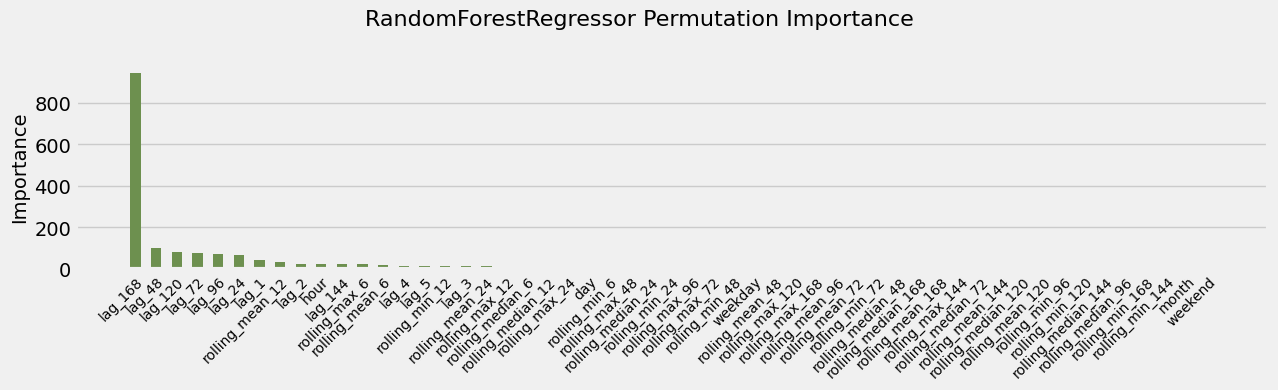

In [52]:
# вызов функции plot_permutation_importances
plot_permutation_importances(rf_model, model_name)

- наиболее важный признак (с большим отрывом) — `lag_168`;
- из 10 наиболее важных признаков 8 — признаки `lag`;
- permutation impotances большинства признаков близки к нулю (стоит провести отбор признаков).

In [53]:
# отбор признаков
rfecv = RFECV(estimator = rf_model, 
              step      = 1, 
              cv        = tscv, 
              scoring   = 'neg_mean_squared_error')

rfecv.fit(features_train, target_train)

# создание списка с отобранными признаками
rf_features = list(rfecv.get_feature_names_out())

# вывод на экран количества и названий отобранных признаков
print(f'Оптимальное количество признаков: {rfecv.n_features_}')
print(f'Оптимальные признаки: {rf_features}')

Оптимальное количество признаков: 18
Оптимальные признаки: ['hour', 'lag_1', 'lag_2', 'lag_4', 'lag_5', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24', 'rolling_mean_96', 'rolling_min_12', 'rolling_max_6']


- в результате отбора признаков их количество сократилось в три раза

In [54]:
# создание препроцессора для RandomForestRegressor с учетом отбора признаков
rf_preprocessor = ColumnTransformer(
    transformers = [('feature selector', 'passthrough', rf_features)]).set_output(transform = 'pandas')

# обновление модели
rf_model_fs = MyPipeline(steps = [('preprocessor', rf_preprocessor),
                                  ('regressor', RandomForestRegressor(random_state = random_state))
                                  ])

# расчет среднего значения RMSE на обучающей выборке с учетом отбора признаков
scores = cross_val_score(rf_model_fs, 
                         features_train, 
                         target_train, 
                         scoring = 'neg_mean_squared_error', 
                         cv      = tscv)

# сохранение значения RMSE в таблицу models_data
models_data.loc[model_name, 'f_selection_rmse'] = np.mean(np.sqrt(np.abs(scores)))

# вывод на экран значений rmse до и после отбора признаков
metrics_to_display = ['baseline_rmse', 'f_selection_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

,RandomForestRegressor
baseline_rmse,22.154854
f_selection_rmse,22.141857


- отбор признаков незначительно улучшил значения метрики

### CatBoostRegressor

In [55]:
model_name = 'CatBoostRegressor'

In [56]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial):
    
    # определение пространства поиска значений гиперпараметров
    params = {'iterations'      : trial.suggest_int('iterations', 50, 1000, step = 50), 
              'learning_rate'   : trial.suggest_float('learning_rate', 1e-4, 3e-1, log = True),
              'depth'           : trial.suggest_int('depth', 2, 10),
              'l2_leaf_reg'     : trial.suggest_float('l2_leaf_reg', 1e-3, 1e3, log = True),
              'random_strength' : trial.suggest_float('random_strength', 1e-3, 1e3, log = True)}
    
    # обновление гиперпараметров модели
    cb_model.set_params(**params)
    
    # расчет среднего значения RMSE на обучающей выборке   
    scores = cross_val_score(cb_model, 
                             features_train, 
                             target_train, 
                             scoring = 'neg_mean_squared_error', 
                             cv      = tscv)

    return np.mean(np.sqrt(np.abs(scores)))

In [57]:
# оптимизация гиперпараметров
cb_study = optuna.create_study(direction = 'minimize', sampler = sampler)
cb_study.optimize(objective, n_trials = 100, show_progress_bar = True)

# сохранение результатов оптимизации
joblib.dump(cb_study, os.path.join(path, 'cb_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_rmse'] = cb_study.best_value
models_data.loc[model_name, 'best_params'] = [cb_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in cb_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# обновление гиперпараметров модели
cb_model.set_params(**cb_study.best_params)

# вывод на экран значений rmse до и после оптимизации
metrics_to_display = ['baseline_rmse', 'opt_hparams_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

iterations: 900
learning_rate: 0.00664483574802299
depth: 8
l2_leaf_reg: 0.021229130614660127
random_strength: 0.08729131925429584



,CatBoostRegressor
baseline_rmse,23.107445
opt_hparams_rmse,21.914806


- оптимизация гиперпараметров улучшила значение метрики

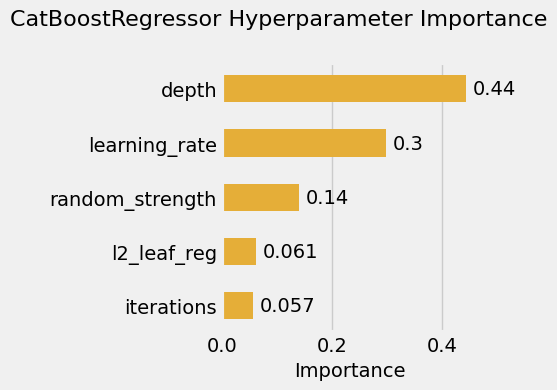

In [58]:
# вызов функции plot_param_importances
plot_param_importances(cb_study, model_name, 4)

- наиболее важный гиперпараметр — `depth`

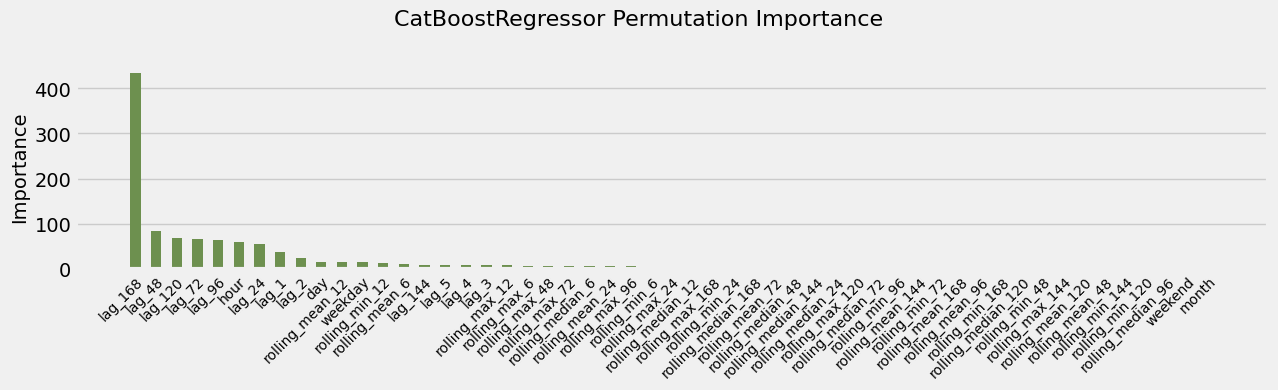

In [59]:
# вызов функции plot_permutation_importances
plot_permutation_importances(cb_model, model_name)

- наиболее важный признак (с большим отрывом) — `lag_168`;
- из 10 наиболее важных признаков 8 — признаки - `lag`;
- permutation impotances большинства признаков близки к нулю (стоит провести отбор признаков).

Проведем отбор признаков:

In [60]:
# отбор признаков
rfecv = RFECV(estimator = cb_model, 
              step      = 1, 
              cv        = tscv, 
              scoring   = 'neg_mean_squared_error')

rfecv.fit(features_train, target_train)

# создание списка с отобранными признаками
cb_features = list(rfecv.get_feature_names_out())

# вывод на экран количества и названий отобранных признаков
print(f'Оптимальное количество признаков: {rfecv.n_features_}')
print(f'Оптимальные признаки: {cb_features}')

Оптимальное количество признаков: 22
Оптимальные признаки: ['day', 'weekday', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24', 'rolling_mean_168', 'rolling_min_12', 'rolling_max_6', 'rolling_max_12', 'rolling_max_48', 'rolling_max_96']


- в результате отбора признаков их количество сократилось в два с половиной раза

In [61]:
# создание препроцессора для CatBoostRegressor с учетом отбора признаков
cb_preprocessor = ColumnTransformer(
    transformers = [('feature selector', 'passthrough', cb_features)]).set_output(transform = 'pandas')

# обновление модели
cb_model_ho_fs = MyPipeline(steps = [
    ('preprocessor', cb_preprocessor),
    ('regressor', CatBoostRegressor(random_state = random_state, 
                                    verbose      = False))
    ])

cb_model_ho_fs['regressor'].set_params(**cb_study.best_params)

# расчет среднего значения RMSE на обучающей выборке с учетом отбора признаков
scores = cross_val_score(cb_model_ho_fs, 
                         features_train, 
                         target_train, 
                         scoring = 'neg_mean_squared_error', 
                         cv      = tscv)

# сохранение значения RMSE в таблицу models_data
models_data.loc[model_name, 'f_selection_rmse'] = np.mean(np.sqrt(np.abs(scores)))

# вывод на экран значений rmse до и после отбора признаков
metrics_to_display = ['baseline_rmse', 'opt_hparams_rmse', 'f_selection_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

,CatBoostRegressor
baseline_rmse,23.107445
opt_hparams_rmse,21.914806
f_selection_rmse,21.843704


- отбор признаков дополнительно незначительно улучшил значения метрики

### XGBRegressor

In [62]:
model_name = 'XGBRegressor'

In [63]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial):
    
    # определение пространства поиска значений гиперпараметров
    params = {'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000, step = 50),
              'eta'              : trial.suggest_float('eta', 1e-4, 3e-1, log = True),
              'max_depth'        : trial.suggest_int('max_depth', 2, 10),
              'gamma'            : trial.suggest_float('gamma', 1e-3, 1e3, log = True),
              'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e3, log = True),
              'alpha'            : trial.suggest_float('alpha', 1e-3, 1e3, log = True),
              'lambda'           : trial.suggest_float('lambda', 1e-3, 1e3, log = True),
              'scale_pos_weight' : trial.suggest_categorical('scale_pos_weight', [1, 73/27]),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
              'subsample'        : trial.suggest_float('subsample', 0.1, 1.0)}
    
    # обновление гиперпараметров модели
    xgb_model.set_params(**params)
    
    # расчет среднего значения RMSE на обучающей выборке  
    scores = cross_val_score(xgb_model, 
                             features_train, 
                             target_train, 
                             scoring = 'neg_mean_squared_error', 
                             cv      = tscv)

    return np.mean(np.sqrt(np.abs(scores)))

In [64]:
# оптимизация гиперпараметров
xgb_study = optuna.create_study(direction = 'minimize', sampler = sampler)
xgb_study.optimize(objective, n_trials = 100, show_progress_bar = True)

# сохранение результатов оптимизации
joblib.dump(xgb_study, os.path.join(path, 'xgb_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_rmse'] = xgb_study.best_value
models_data.loc[model_name, 'best_params'] = [xgb_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in xgb_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# обновление гиперпараметров модели 
xgb_model.set_params(**xgb_study.best_params)

# вывод на экран значений rmse до и после оптимизации
metrics_to_display = ['baseline_rmse', 'opt_hparams_rmse']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

n_estimators: 1000
eta: 0.00583664916384661
max_depth: 2
gamma: 18.5171520268338
min_child_weight: 12.452516046236019
alpha: 0.03789124347602786
lambda: 1.6774190460489957
scale_pos_weight: 1
colsample_bytree: 0.5366570791499045
subsample: 0.33855822403024954



,XGBRegressor
baseline_rmse,26.44778
opt_hparams_rmse,21.743432


- оптимизация гиперпараметров значительно улучшила значение метрики

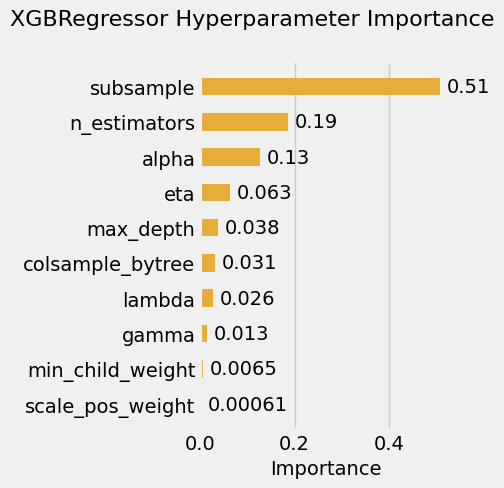

In [65]:
# вызов функции plot_param_importances
plot_param_importances(xgb_study, model_name, 5)

- наиболее важные гиперпараметры — `subsample`, `alpha` и `n_estimators`

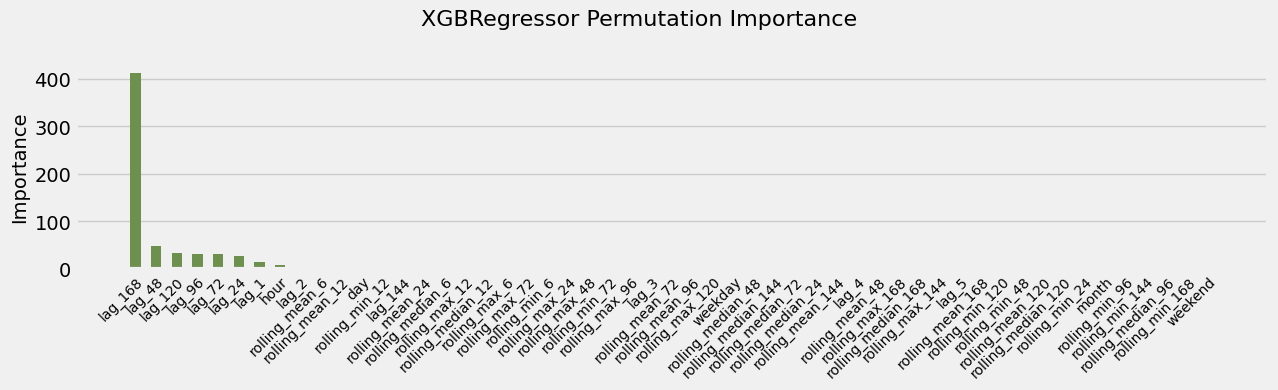

In [66]:
# вызов функции plot_permutation_importances
plot_permutation_importances(xgb_model, model_name)

- наиболее важный признак (с большим отрывом) — `lag_168`;
- из 10 наиболее важных признаков 8 — признаки - `lag`;
- permutation impotances большинства признаков близки к нулю (стоит провести отбор признаков).

Проведем отбор признаков:

In [67]:
# отбор признаков
rfecv = RFECV(estimator = xgb_model, 
              step      = 1, 
              cv        = tscv, 
              scoring   = 'neg_mean_squared_error')

rfecv.fit(features_train, target_train)

# создание списка с отобранными признаками
xgb_features = list(rfecv.get_feature_names_out())

# вывод на экран количества и названий отобранных признаков
print(f'Оптимальное количество признаков: {rfecv.n_features_}')
print(f'Оптимальные признаки: {xgb_features}')

Оптимальное количество признаков: 53
Оптимальные признаки: ['month', 'day', 'weekday', 'weekend', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24', 'rolling_mean_48', 'rolling_mean_72', 'rolling_mean_96', 'rolling_mean_120', 'rolling_mean_144', 'rolling_mean_168', 'rolling_median_6', 'rolling_median_12', 'rolling_median_24', 'rolling_median_48', 'rolling_median_72', 'rolling_median_96', 'rolling_median_120', 'rolling_median_144', 'rolling_median_168', 'rolling_min_6', 'rolling_min_12', 'rolling_min_24', 'rolling_min_48', 'rolling_min_72', 'rolling_min_96', 'rolling_min_120', 'rolling_min_144', 'rolling_min_168', 'rolling_max_6', 'rolling_max_12', 'rolling_max_24', 'rolling_max_48', 'rolling_max_72', 'rolling_max_96', 'rolling_max_120', 'rolling_max_144', 'rolling_max_168']


- для модели `XGBRegressor` оптимальное количество признаков равно общему количеству признаков

In [68]:
models_data.loc[model_name, 'f_selection_rmse'] = models_data.loc[model_name, 'opt_hparams_rmse']

### Статистические модели

Также обучим четыре статистических модели:
- `SeasonalNaive`;
- `AutoETS`;
- `AutoARIMA`; и
- `MSTL`.

In [69]:
# создание списка со статистическими моделями
stat_models = [SeasonalNaive(season_length = 168),
               AutoETS(season_length = 24),
               AutoARIMA(season_length = 24),
               MSTL(season_length = [24, 168])]

stat_models_names = ['SeasonalNaive', 'AutoETS', 'AutoARIMA', 'MSTL']

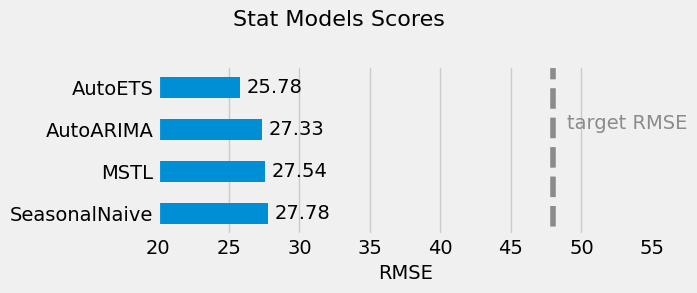

In [70]:
# для каждой статистической модели
for model_name, model in zip(stat_models_names, stat_models):
    
    sf = StatsForecast(models = [model],
                       freq = 'H')
    
    scores = []

    # расчет среднего значения RMSE на обучающей выборке
    for i, (train_index, test_index) in enumerate(tscv.split(target_train_stat)):
        y_train, y_test  = target_train_stat.iloc[train_index], target_train_stat.iloc[test_index]
        sf.fit(y_train)
        score = mean_squared_error(y_test.y, sf.predict(len(y_test))[model_name], squared = False)
        scores.append(score)

    # сохранение результатов   
    models_data.loc[model_name, 'baseline_rmse'] = np.mean((np.abs(scores))

# вызов функции plot_scores
plot_scores(models_data.loc[stat_models_names, 'baseline_rmse'], 'Stat Models Scores', 3)

- лучшее среднее значение `RMSE` на обучающей выборке показала статистическая модель `AutoETS`;
- все статистические модели демонстрируют на обучающей выборке качество прогноза `RMSE` лучше целевого

### Сравнение моделей

Сравним значения RMSE ML-моделей (после оптимизации гиперпараметров и отбора признаков) и статистичеких моделей:

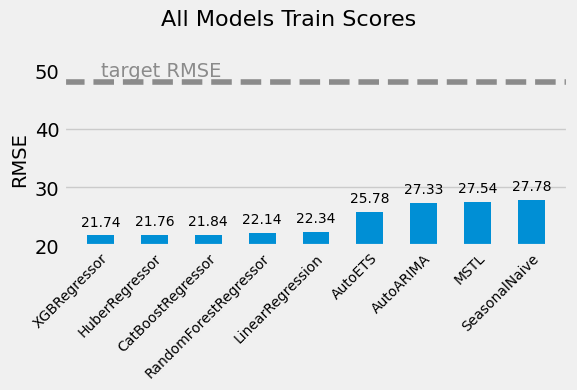

In [71]:
# вывод на экран RMSE всех моделей после оптимизации гиперпараметров и отбора признаков
data = pd.concat([
    models_data.loc[ml_models_names, 'f_selection_rmse'], 
    models_data.loc[stat_models_names, 'baseline_rmse']
    ]).sort_values()

fig, ax = plt.subplots(figsize = (6, 4))

bars = ax.bar(x      = data.index,
              height = data.values,
              width  = 0.5)

ax.axhline(y         = 48, 
           color     = '#8b8b8b', 
           linestyle = '--')

ax.text(0, 49, 'target RMSE', color = '#8b8b8b')

ax.grid(axis='x')

ax.bar_label(bars, 
             fmt      = '%.2f', 
             padding  = 5,
             fontsize = 10)

plt.xticks(fontsize      = 10,
           rotation      = 45, 
           ha            = 'right', 
           rotation_mode = 'anchor')

ax.set_ylim(20, 50)

ax.set_ylabel('RMSE', fontsize = 14)

fig.suptitle('All Models Train Scores', fontsize = 16)

plt.tight_layout()
plt.show()

В результате оптимизации гиперпараметров и отбора признаков:

-  лучшее среднее значение `RMSE` на обучающей выборке (`21.74`) показала модель `XGBRegressor` (однако разница между ее результатами и результатами `HuberRegressor` незначительна);
- все модели демонстрируют на обучающей выборке качество прогноза `RMSE` лучше целевого значения `48`.

### Ансамбль

Попробуем увеличить значение метрики, составив ансамбль из ML-моделей:

In [72]:
# создание списка с моделями с оптимизированными гиперпараметрами и отобранными признаками
ml_models_ho_fs = [lr_model_fs, hr_model_ho_fs, rf_model_fs, cb_model_ho_fs, xgb_model]

In [73]:
# создание списка с моделями и их названиями
estimators = [('LinearRegression', lr_model_fs),
              ('HuberRegressor', hr_model_ho_fs),
              ('RandomForestRegressor', rf_model_fs),
              ('CatBoostRegressor', cb_model_ho_fs),
              ('XGBRegressor', xgb_model)]

In [74]:
# создание ансамблевой модели
voting_model = VotingRegressor(estimators = estimators)

In [75]:
# добавление модели VotingRegressor и ее названия в списки ml_models и ml_models_names
ml_models_ho_fs.append(voting_model)
ml_models_names.append('VotingRegressor')

### Выводы

На данном этапе мы обучили пять ML-моделей:
- `LinearRegression`;
- `HuberRegressor`;
- `RandomForestRegressor`;
- `CatBoostRegressor`; и
- `XGBRegressor`.

Для каждой из моделей мы оптимизировали гиперпараметры и провели отбор признаков.

Мы также обучили четыре статистических модели:
- `SeasonalNaive`;
- `AutoETS`;
- `AutoARIMA`; и
- `MSTL`.

В результате оптимизации гиперпараметров и отбора признаков:

-  лучшее среднее значение `RMSE` на обучающей выборке (`21.74`) показала модель `XGBRegressor` (однако разница между ее результатами и результатами `HuberRegressor` незначительна);
- все модели демонстрируют на обучающей выборке качество прогноза `RMSE` лучше целевого значения `48`.

Мы также составили из ML-моделей с оптимизированными гиперпараметрами и отобранными признаками ансамблевую модель `VotingRegressor`.

## Тестирование моделей

Протестируем модели на тестовой выборке:

In [76]:
# для каждой ML-модели
for model_name, model in zip(ml_models_names, ml_models_ho_fs):

    # обучение на обучающей выборке
    model.fit(features_train, target_train)

    # получение и сохранение значений RMSE на тестовой выборке
    score = mean_squared_error(target_test, model.predict(features_test), squared = False)
    models_data.loc[model_name, 'test_rmse'] = score

In [77]:
# для каждой статистической модели
for model_name, model in zip(stat_models_names, stat_models):
    
    sf = StatsForecast(models = [model],
                       freq = 'H')

    # обучение на обучающей выборке
    sf.fit(target_train_stat)

    # получение и сохранение значений RMSE на тестовой выборке
    score = mean_squared_error(target_test, sf.predict(len(features_test))[model_name], squared = False) 
    models_data.loc[model_name, 'test_rmse'] = score

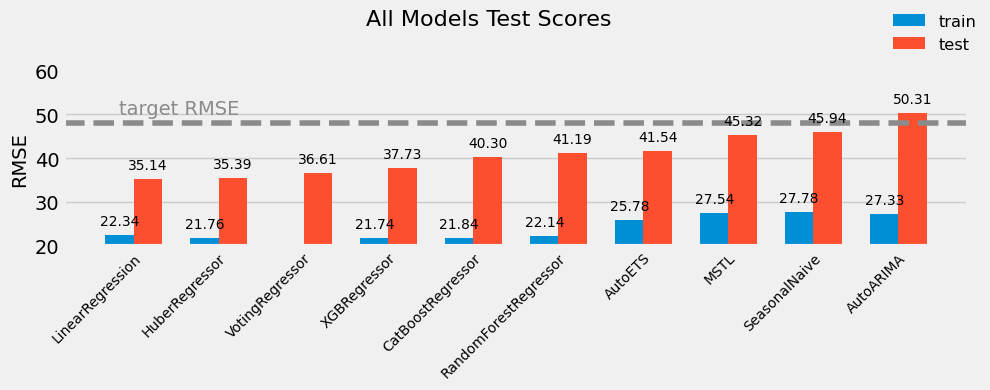

In [78]:
# вывод на экран RMSE моделей на обучающей и тестовой выборках
data_train = pd.concat([
    models_data.loc[ml_models_names[:5], 'f_selection_rmse'], 
    models_data.loc[stat_models_names, 'baseline_rmse']])

data_train.loc['VotingRegressor'] = np.nan

data_test = models_data['test_rmse']

inds = np.argsort(data_test.values)

pos = np.arange(len(data_test))

fig = plt.figure(figsize = (10, 4))

bars_train = plt.bar(x      = pos,
                     height = data_train[inds].values,
                     width  = 1/3,
                     label  = 'train')

plt.bar_label(bars_train, 
             fmt     = '%.2f', 
             padding = 5,
             fontsize = 10)

bars_test = plt.bar(x = pos + 1/3,
                    height = data_test[inds].values,
                    width = 1/3,
                    label = 'test')

plt.bar_label(bars_test, 
              fmt     = '%.2f', 
              padding = 5,
              fontsize = 10)

plt.axhline(y         = 48, 
           color     = '#8b8b8b', 
           linestyle = '--')

plt.text(0, 50, 'target RMSE', color = '#8b8b8b')

plt.xticks(ticks = pos + 1/6,
           labels        = data_test[inds].index,
           fontsize      = 10,
           rotation      = 45, 
           ha            = 'right', 
           rotation_mode = 'anchor')

plt.ylim(20, 60)

plt.ylabel('RMSE', fontsize = 14)

plt.grid(axis='x')

fig.legend(loc            = 'upper right', 
           frameon        = False,
           fontsize       = 'small')

fig.suptitle('All Models Test Scores', fontsize = 16)

plt.tight_layout()
plt.show()

- лучшее значение `RMSE` на тестовой выборке (`35.14`) показала модель `LinearRegression`, что на 27% лучше целевого значения;
- за исключением статистической модели `AutoArima`, все модели показали значения метрики лучше целевого значения `48`;
- все модели показали на тестовой выборке значения `RMSE` сильно хуже значений на обучающей выборке;
- ансамблевая модель `VotingRegressor` показала только третий результат.

Посмотрим, как соотносятся предсказания и предсказываемые значения целевого признака на примере модели `LinearRegression`, показавшей лучшее значение `RMSE` на тестовой выборке: 

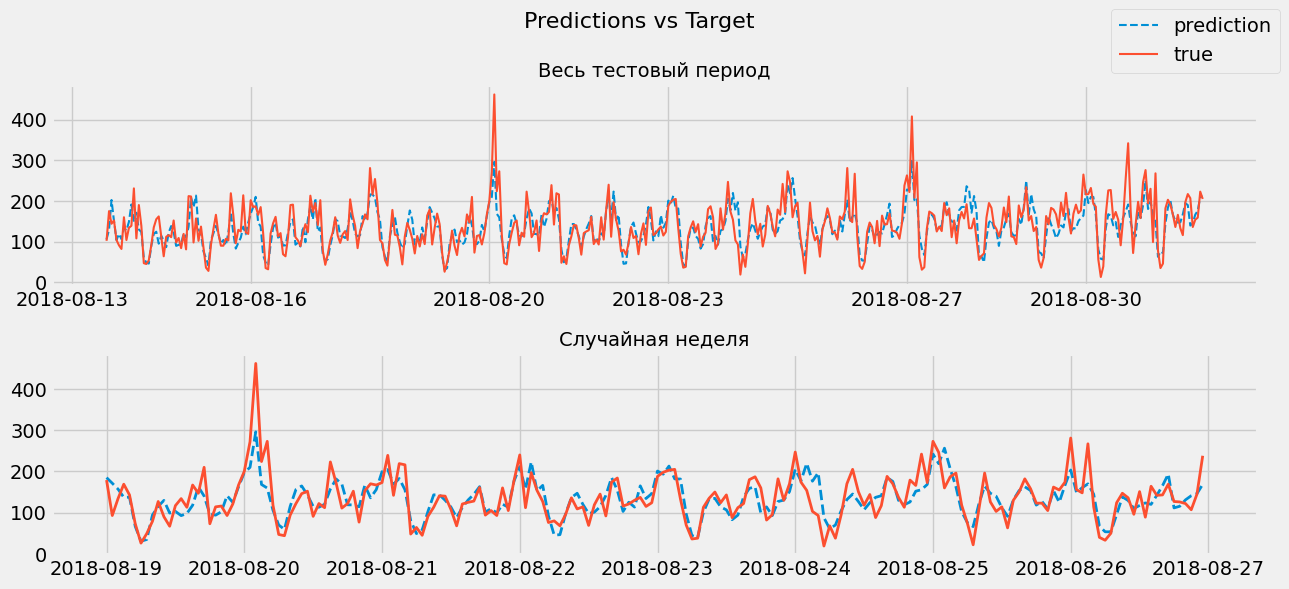

In [79]:
# построение графиков предсказаний модели LinearRegression и предсказываемых значений
lr_model_preds = pd.Series(lr_model_fs.predict(features_test), target_test.index)

fig, ax = plt.subplots(nrows = 2, figsize = (13,6))

ax[0].plot(lr_model_preds, 
           linewidth = 1.5,
           linestyle = '--',
           label = 'prediction')

ax[0].plot(target_test, 
           linewidth=1.5,
           label = 'true')

loc = WeekdayLocator(byweekday = [MO, TH], 
                     interval  = 1)

ax[0].xaxis.set_major_locator(loc)

ax[1].plot(lr_model_preds['2018-08-19' : '2018-08-26'], 
           linewidth = 2,
           linestyle = '--')

ax[1].plot(target_test['2018-08-19' : '2018-08-26'], 
           linewidth= 2)

fig.legend()

ax[0].set_title('Весь тестовый период', fontsize = 14)
ax[1].set_title('Случайная неделя', fontsize = 14)

fig.suptitle('Predictions vs Target', fontsize = 16)

plt.tight_layout()
plt.show()

- модель `LinearRegression` хорошо приближает дневную и недельную сезонности, но недостаточно хорошо - выбросы.

### Выводы

На данном этапе мы протестировали модели на тестовой выборке:

- лучшее значение `RMSE` на тестовой выборке (`35.14`) показала модель `LinearRegression`, что на 27% лучше целевого значения;
- за исключением статистической модели `AutoArima`, все модели показали значения метрики лучше целевого значения `48`;
- все модели показали на тестовой выборке значения `RMSE` сильно хуже значений на обучающей выборке;
- ансамблевая модель `VotingRegressor` показала только третий результат;
- модель `LinearRegression` хорошо приближает дневную и недельную сезонности, но недостаточно хорошо - выбросы.

## Общие выводы

**Введение**

*Задача*

Перед нами была поставлена задача построить модель для прогнозирования количества заказов такси в аэропортах на следующий час для агрегатора такси.

На основе предсказаний модели планируется привлекать больше водителей в периоды пиковой нагрузки.

Модель должна демонстрировать качество прогноза `RMSE` не больше `48` на тестовой выборке размером 10% от исходных данных.

*Предоставленные данные*

Исторические данные компании о заказах такси в аэропортах.

Согласно описанию к данным, количество заказов (целевой признак) — значения столбца `num_orders`.

*Основные этапы работы*

Работа над задачей включала шесть основных этапов:

1. загрузка и первичное изучение данных;
2. подготовка данных для исследовательского анализа;
3. исследовательский анализ данных;
4. подготовка данных для обучения моделей;
5. обучение моделей; и
6. тестирование моделей.

**Загрузка и первичное изучение данных**

На данном этапе мы загрузили данные и провели их первичное изучение.

По его итогам мы установили:

- в датасете 26 496 объектов;
- один объект содержит информацию о количестве заказов в определенные дату и время;
- по каждому объекту доступно 2 признака (включая целевой): `datetime` (календарный признак) и `num_orders` (количественный целевой признак);
- значения признака `datetime` имеют интервал 10 минут (для решения задачи необходимо ресемплировать данные) и расположены в хронологическом порядке;
- датасет не содержит явных пропусков и дубликатов.

**Подготовка данных для исследовательского анализа**

На данном этапе мы ресемплировали данные, используя интервал `1 час`.

**Исследовательский анализ данных**

На данном этапе мы исследовали:
- распределение значений количества заказов в час; и
- временной ряд.

*Количество заказов в час*

- данные распределены ассиметрично (наблюдается позитивная скошенность);
- есть выбросы начиная с 180 заказов.

*Времеменной ряд*

Для решения задачи были предоставлены данные за 7 месяцев.
Временной ряд стационарен.

Мы наблюдали:
- восходящий тренд; 
- дневную и недельную сезонности (используем данные наблюдения при создании признаков);
- увеличение амплитуды остатка ближе к концу временного ряда; а также
- сильную автокорреляцию `lag 0` с `lag 1`, `lag 24`, `lag 48`, `lag 72`, `lag 96`, `lag 120`, `lag 144` и `lag 168` (используем данные наблюдения при создании признаков).

**Подготовка данных для обучения моделей**

На данном этапе мы:

- создали дополнительные признаки (календарные признаки, lag и rolling mean, median, min, max);
- создали отдельные переменные с признаками и целевым признаком;
- разделили данные на обучающую и тестовую выборки; и
- подготовили обучающую выборку для статистических моделей.

**Обучение моделей**

На данном этапе мы обучили пять ML-моделей:
- `LinearRegression`;
- `HuberRegressor`;
- `RandomForestRegressor`;
- `CatBoostRegressor`; и
- `XGBRegressor`.

Для каждой из моделей мы оптимизировали гиперпараметры и провели отбор признаков.

Мы также обучили четыре статистических модели:
- `SeasonalNaive`;
- `AutoETS`;
- `AutoARIMA`; и
- `MSTL`.

В результате оптимизации гиперпараметров и отбора признаков:

-  лучшее среднее значение `RMSE` на обучающей выборке (`21.74`) показала модель `XGBRegressor` (однако разница между ее результатами и результатами `HuberRegressor` незначительна);
- все модели демонстрируют на обучающей выборке качество прогноза `RMSE` лучше целевого значения `48`.

Мы также составили из ML-моделей с оптимизированными гиперпараметрами и отобранными признаками ансамблевую модель `VotingRegressor`.

**Тестирование моделей**

На данном этапе мы протестировали модели на тестовой выборке:

- лучшее значение `RMSE` на тестовой выборке (`35.14`) показала модель `LinearRegression`, что на 27% лучше целевого значения;
- за исключением статистической модели `AutoArima`, все модели показали значения метрики лучше целевого значения `48`;
- все модели показали на тестовой выборке значения `RMSE` сильно хуже значений на обучающей выборке;
- ансамблевая модель `VotingRegressor` показала только третий результат;
- модель `LinearRegression` хорошо приближает дневную и недельную сезонности, но недостаточно хорошо - выбросы.